In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from scipy.special import expit

sns.set_style('whitegrid')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Часть 0. SVM, LR и калибровка вероятностей. 

Сгенерируем синтетические данные.

In [2]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

__Задание 1.__ Обучение и применение метода опорных векторов и логистической регрессии.

__(1 балл)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей). __Здесь и далее, если не сказано иначе, подбирайте оптимальные гиперпараметры с точки зрения AUC-PR.__

In [3]:
svc = LinearSVC(max_iter=100000).fit(X_train, y_train)
svc_pred = svc.decision_function(X_test)
print(svc.score(X_test, y_test))
print('SVC ROC-AUC:', roc_auc_score(y_test, svc_pred))

# svc_pred = svc.decision_function(X_test)
# pr, rec, _ = precision_recall_curve(y_test, svc_pred)
# fpr, tpr, _ = roc_curve(y_test, svc_pred)

# print('AUC-PR = %.5f' % auc(rec, pr), '\n', 'AUC-ROC = %.5f' % auc(fpr, tpr), sep='')

0.7716666666666666
SVC ROC-AUC: 0.8476457642781673


Площадь под кривой не равна $\frac{1}{2}$, что хорошо.

C - это коэффициент регуляризации, который позволяет регулировать отношение между максимизацией ширины разделяющей полосы и минимизацией суммарной ошибки. Пока что он равен 1.

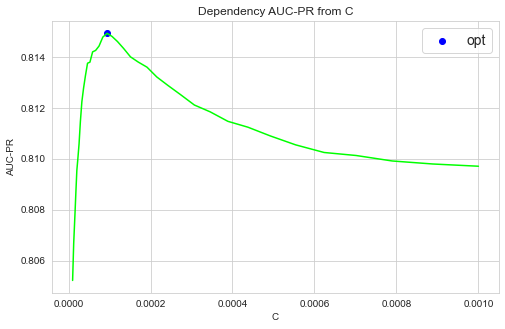

Best C for SVM = 0.0000942668


In [5]:
from sklearn.metrics import precision_recall_curve, auc

def auc_pr(y, y_preds):
    assert y.shape == y_preds.shape
    pr, rec, _ = precision_recall_curve(y, y_preds)
    return auc(rec, pr)


_, X_valid, _, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

Cs = np.logspace(-5, -3, 40)
params = {}
for C_ in Cs:
    svc_valid = LinearSVC(max_iter=100000, C=C_).fit(X_valid, y_valid)
    svc_valid_pred = svc_valid.decision_function(X_valid)
    params[C_] = auc_pr(y_valid, svc_valid_pred)

C_opt = max(params, key=params.get)
auc_opt = params[C_opt]
    
plt.figure(figsize=(8, 5))
plt.plot(list(params.keys()), list(params.values()), color='lime')
plt.scatter(C_opt, auc_opt, color='b', label='opt')
plt.xlabel('C')
plt.ylabel('AUC-PR')
plt.title('Dependency AUC-PR from C')
plt.legend(shadow=False, fontsize=14)
plt.show()

print("Best C for SVM = %.10f" % C_opt)

На тестовой части постройте ROC и PR кривые, а также посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора (который на каждом объекте выдаёт один из двух классов с равными вероятностями).

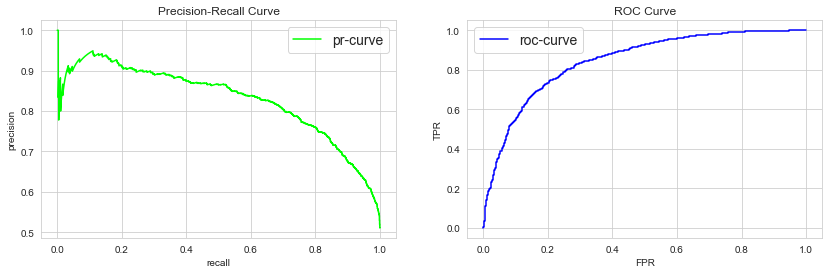

SVM AUC-PR = 0.82966
SVM AUC-ROC = 0.84497


In [6]:
from sklearn.metrics import roc_curve

def draw_PR(rec, pr, ax=None):
    if ax is None:
        ax = plt.gca()
        
    ax.plot(rec, pr, color='lime', label='pr-curve')
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title('Precision-Recall Curve')
    ax.legend(shadow=False, fontsize=14)
    return ax

def draw_ROC(fpr, tpr, ax=None):
    if ax is None:
        ax = plt.gca()
        
    ax.plot(fpr, tpr, color='b', label='roc-curve')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title('ROC Curve')
    ax.legend(shadow=False, fontsize=14)
    return ax


svc = LinearSVC(max_iter=100000, C=C_opt).fit(X_train, y_train)
svc_pred = svc.decision_function(X_test)
pr, rec, _ = precision_recall_curve(y_test, svc_pred)
fpr, tpr, _ = roc_curve(y_test, svc_pred)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
ax1 = draw_PR(rec, pr, ax=ax1)
ax2 = draw_ROC(fpr, tpr, ax=ax2)
plt.show()

print('SVM AUC-PR = %.5f' % auc(rec, pr), '\n', 'SVM AUC-ROC = %.5f' % auc(fpr, tpr), sep='')

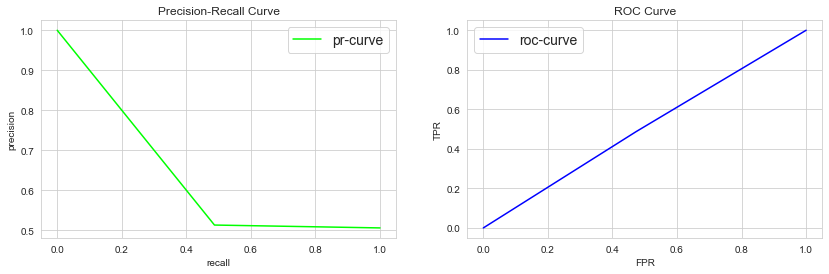

SVM AUC-PR = 0.62966
SVM AUC-ROC = 0.50689


In [7]:
l = y_test.shape
y_rnd = np.random.randint(low=0, high=2, size=l, dtype=int)

pr, rec, _ = precision_recall_curve(y_test, y_rnd)
fpr, tpr, _ = roc_curve(y_test, y_rnd)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
ax1 = draw_PR(rec, pr, ax=ax1)
ax2 = draw_ROC(fpr, tpr, ax=ax2)
plt.show()

print('SVM AUC-PR = %.5f' % auc(rec, pr), '\n', 'SVM AUC-ROC = %.5f' % auc(fpr, tpr), sep='')

Понятно, что случайный классификатор покажет себя хуже. Кроме того, мы видим, что `AUC-ROC` для него равен $\frac{1}{2}$, что говорит о том, что модель имеет чисто случайный характер. Как говорилось на лекции, это худший случай.

А теперь проделайте все то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление всех метрик и построение кривых. Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

In [8]:
logreg = LogisticRegression(max_iter=100000, penalty='l2', solver='liblinear').fit(X_train, y_train)
lr_pred = logreg.decision_function(X_test)
print('LR ROC-AUC:', roc_auc_score(y_test, lr_pred))

LR ROC-AUC: 0.8478706820564953


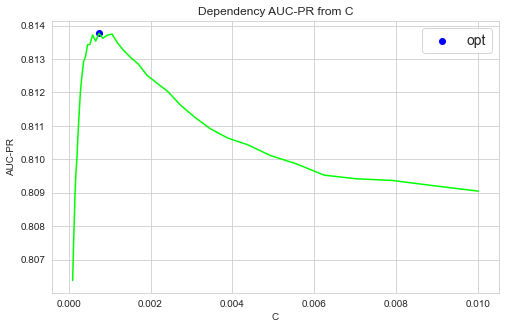

Best C for LR = 0.0007443803


In [10]:
Cs = np.logspace(-4, -2, 40)
params_lr = {}
for C_ in Cs:
    lr_valid = LogisticRegression(max_iter=100000, penalty='l2', solver='liblinear', C=C_).fit(X_valid, y_valid)
    lr_valid_pred = lr_valid.decision_function(X_valid)
    params_lr[C_] = auc_pr(y_valid, lr_valid_pred)

C_opt_lr = max(params_lr, key=params_lr.get)
auc_opt_lr = params_lr[C_opt_lr]
    
plt.figure(figsize=(8, 5))
plt.plot(list(params_lr.keys()), list(params_lr.values()), color='lime')
plt.scatter(C_opt_lr, auc_opt_lr, color='b', label='opt')
plt.xlabel('C')
plt.ylabel('AUC-PR')
plt.title('Dependency AUC-PR from C')
plt.legend(shadow=False, fontsize=14)
plt.show()

print("Best C for LR = %.10f" % C_opt_lr)

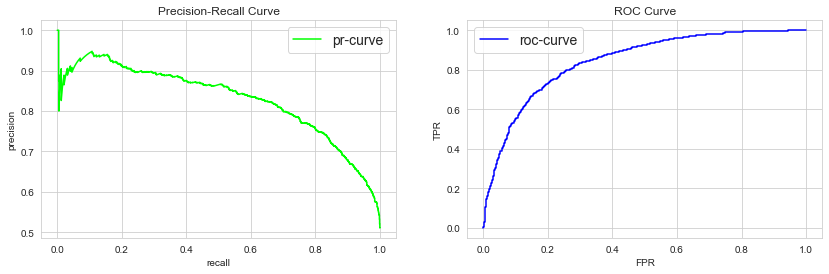

LR AUC-PR = 0.82954
LR AUC-ROC = 0.84455


In [11]:
logreg = LogisticRegression(max_iter=100000, penalty='l2', solver='liblinear', C=C_opt_lr).fit(X_train, y_train)
lr_pred = logreg.decision_function(X_test)

pr, rec, _ = precision_recall_curve(y_test, lr_pred)
fpr, tpr, _ = roc_curve(y_test, lr_pred)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
ax1 = draw_PR(rec, pr, ax=ax1)
ax2 = draw_ROC(fpr, tpr, ax=ax2)
plt.show()

print('LR AUC-PR = %.5f' % auc(rec, pr), '\n', 'LR AUC-ROC = %.5f' % auc(fpr, tpr), sep='')

* SVM AUC-PR = 0.82965
* SVM AUC-ROC = 0.84497

* LR AUC-PR = 0.82954
* LR AUC-ROC = 0.84455

Практически идентично, но SVM чуть лучше.

В названии метода опорных векторов присутствуют некоторые "опорные векторы". Сгенерируйте синтетические данные с помощью `make_classification` с 2 признаками, обучите на нём метод опорных векторов. Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`). В этот раз, если необходимо, вместо `LinearSVC` воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах.

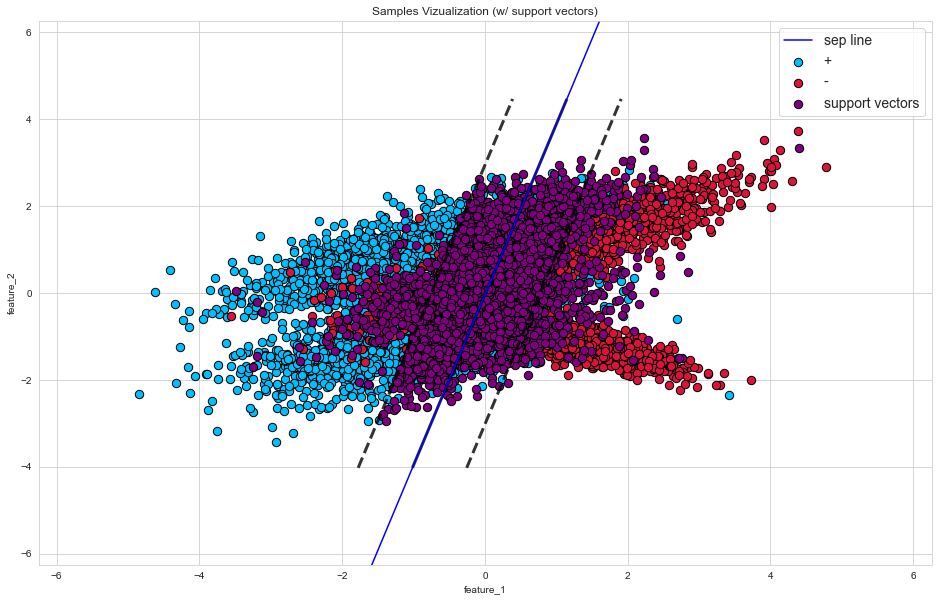

In [12]:
X, y = make_classification(n_samples=20000, n_features=2, n_redundant=0, random_state=10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

from sklearn.svm import SVC
model = SVC(kernel='linear').fit(X_train, y_train)
weights = model.coef_[0]
a = - weights[0] / weights[1]

def get_grid(X_train):
    xlim = [X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5]
    ylim = [X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5]
    return xlim, ylim

xlim, _ = get_grid(X_train)
xx = np.linspace(xlim[0], xlim[1])
yy = a * xx - (model.intercept_[0] / weights[1])

# Украдено с https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html
def plot_svc_decision_function(model, ax=None, support=True, line_c='k'):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x, y = get_grid(X_train)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors=line_c,
               levels=[-1, 0, 1], alpha=0.8,
               linestyles=['--', '-', '--'], linewidths=3)
    
    # plot support vectors
    if support:
        ax.scatter(model.support_vectors_[:, 0],
            model.support_vectors_[:, 1], linewidth=1, c='purple', s=70, edgecolor='k', label='support vectors')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

plt.figure(figsize=(16, 10))
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], edgecolor='k', s=70, color='deepskyblue', label='+')
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], edgecolor='k', s=70, color='crimson', label='-')
plt.plot(xx, yy, label='sep line', color='blue')
plot_svc_decision_function(model)
plt.xlabel('feature_1')
plt.ylabel('feature_2')
plt.xlim(xlim)
plt.ylim(xlim)
plt.title('Samples Vizualization (w/ support vectors)')
plt.legend(shadow=False, fontsize=14)
plt.show()

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor`.

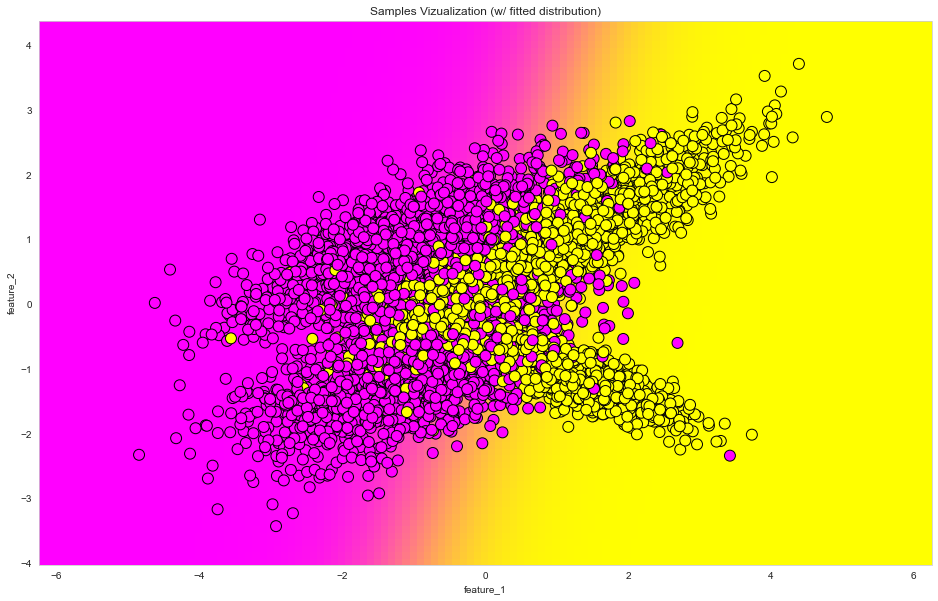

In [13]:
logreg = LogisticRegression(max_iter=100000, penalty='l2', solver='sag').fit(X_train, y_train)

xlim, ylim = get_grid(X_train)
x, y = np.meshgrid(np.arange(xlim[0], xlim[1], 0.1), np.arange(ylim[0], ylim[1], 0.1))
P = logreg.predict_proba(np.c_[x.ravel(), y.ravel()])[:, 1].reshape(x.shape)

cmap='spring'
plt.figure(figsize=(16, 10))
plt.pcolor(x, y, P, cmap=cmap)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=120, cmap=cmap, edgecolor='k')
plt.xlabel('feature_1')
plt.ylabel('feature_2')
plt.title('Samples Vizualization (w/ fitted distribution)')
plt.show()

Да, я нарисовал ЛГБТ-птичку. И что вы мне сделаете?

__Задание 2.__ Калибровка вероятностей.

__(1 балл)__

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

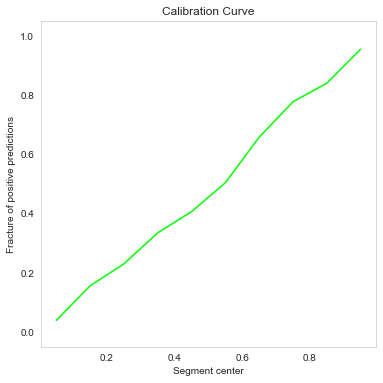

In [15]:
def plot_calibration_curve(y_test, preds, label='', color='b', ax=None):
    if ax is None:
        ax = plt.gca()
    
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) # Здесь был -
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) # Вместо mean был min
        
    ax.plot(bin_middle_points, bin_real_ratios, color=color, label=label)
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('Segment center')
    ax.set_ylabel('Fracture of positive predictions')
    ax.set_title('Calibration Curve')
    ax.grid()
    if label != '':
        ax.legend(shadow=False, fontsize=14)
    return ax

plt.figure(figsize=(6, 6))
ax = plot_calibration_curve(y_test, logreg.predict_proba(X_test)[:, 1], color='lime')
plt.show()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$). Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`). Чем они различаются? Чем вы можете объяснить это?

In [16]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=10)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

logreg = LogisticRegression(max_iter=100000, penalty='l2', solver='sag').fit(X_train, y_train)
lr_pred = logreg.predict_proba(X_test)[:, 1]

svc = SVC(kernel='linear').fit(X_train, y_train)
svc_pred = svc.decision_function(X_test)
svc_pred = (svc_pred - svc_pred.min()) / (svc_pred.max() - svc_pred.min())
svc_pred.min(), svc_pred.max()

(0.0, 1.0)

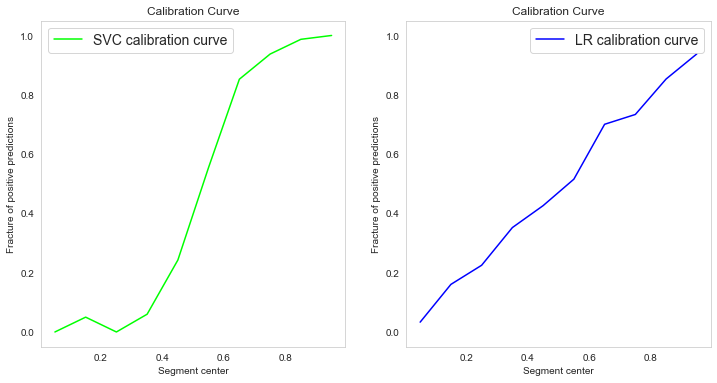

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax1 = plot_calibration_curve(y_test, svc_pred, ax=ax1, color='lime', label='SVC calibration curve')
ax2 = plot_calibration_curve(y_test, lr_pred, ax=ax2, label='LR calibration curve')
plt.show()

Кривая для логистической регрессии хорошо приближает диагональ, SVC - нет.

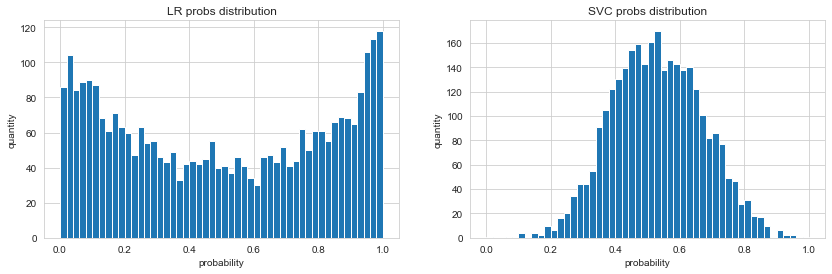

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
ax1.hist(lr_pred, bins=50)
ax2.hist(svc_pred, bins=50)
ax1.set_xlabel('probability')
ax1.set_ylabel('quantity')
ax2.set_ylabel('quantity')
ax2.set_xlabel('probability')
ax1.set_title('LR probs distribution')
ax2.set_title('SVC probs distribution')
plt.show()

Для `LR` частота увечиливается к краям, для `SVC` - наоборот - к центру. Чем объяснимо, увы, не знаю.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

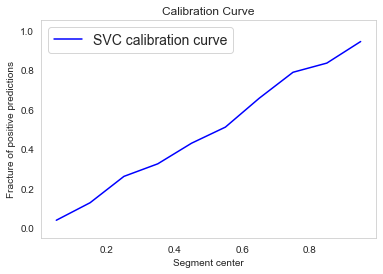

In [19]:
from sklearn.calibration import CalibratedClassifierCV
svc = CalibratedClassifierCV(svc, cv=5).fit(X_train, y_train)
svc_pred = svc.predict_proba(X_test)[:, 1]

svc_pred = (svc_pred - svc_pred.min()) / (svc_pred.max() - svc_pred.min())
ax = plot_calibration_curve(y_test, svc_pred, label='SVC calibration curve')
plt.show()

Стало заметно лучше - почти как у `LR`.

__Бонусное задание (0.5 балла).__ Реализуйте свою функцию для калибровки вероятностей. Опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [17]:
#your code here

# Часть 1. Работа с переменными.

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге, объектом в нем является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит), целевой переменной - ответ клиента (согласился ли он открыть депозит?). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.

In [20]:
import zipfile
import wget
import os
wget.download('https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip', 'data.zip')
os.mkdir('data')
os.replace('data.zip', 'data/data.zip')

with zipfile.ZipFile('data/data.zip', 'r') as zip_ref:
    zip_ref.extractall('data')
df = pd.read_csv('data/bank-additional/bank-additional-full.csv', sep=';')

In [21]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [22]:
df.y = (df.y == 'yes').astype(int)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


__Задание 3 (0.5 балла).__ Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. Один из столбцов в данных не несет информации для решения задачи — какой? Отбросьте его. 



In [23]:
from sklearn.model_selection import StratifiedKFold
X = df.drop(columns=['y', 'duration'])
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c `AUC-PR`) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ваш ответ__: [Цитата](https://stats.stackexchange.com/questions/7207/roc-vs-precision-and-recall-curves/7210#7210): "The key difference is that ROC curves will be the same no matter what the baseline probability is, but PR curves may be more useful in practice for needle-in-haystack type problems or problems where the "positive" class is more interesting than the negative class". Это как раз наш случай. Иными словами, `AUC-PR` более точно отвечает на наш вопрос "What is the probability that this is a real hit given my classifier says it is?".

Еще я думаю, что нам очень важно как можно лучше покрыть положительный класс (т.е. нам важен `recall`), так как каждый непокрытый положительный объект будет классифицирован как отрицательный, что плохо - получаем издержек. То есть, нам страшнее получить FN, чем FP.

In [24]:
num = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
cat = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

Fitting time: 24.56701
LR AUC-PR = 0.42643
LR with scaling AUC-PR = 0.44186


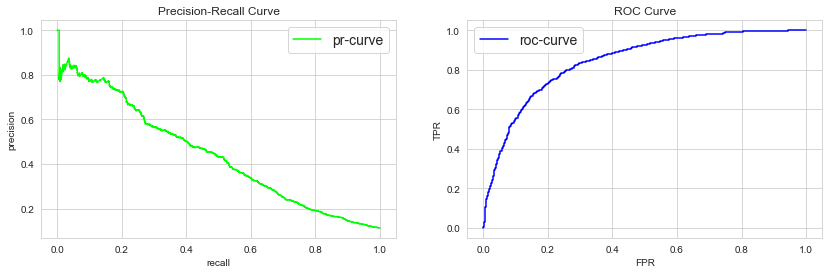

In [25]:
import time
from datetime import datetime
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def construct_model(modeltype, encoder, num, cat, X, y, scaling=False, timeit=True, fit=True):
    column_transformer = ColumnTransformer([
        ('encoding', encoder, cat),
        ('nothing', 'passthrough', num)
    ])
    
    if scaling:
        column_transformer = ColumnTransformer([
            ('encoding', encoder, cat),
            ('scaling', StandardScaler(), num)
        ])

    pipeline = Pipeline(steps=[
            ('transforming', column_transformer),
            ('modeling', modeltype)
    ])
    
    start_time = datetime.now()
    if fit == True:
        logreg = pipeline.fit(X, y)
        if timeit:
            print('Fitting time: %.5f' % (datetime.now() - start_time).total_seconds())
        return pipeline
    return pipeline
    

type_ = LogisticRegression(max_iter=100000, penalty='l2', solver='sag')
logreg = construct_model(type_, OrdinalEncoder(), num, cat, X_train, y_train)
lr_pred = logreg.decision_function(X_test)
pr, rec, _ = precision_recall_curve(y_test, lr_pred)

print('LR AUC-PR = %.5f' % auc(rec, pr))

logreg = construct_model(type_, OrdinalEncoder(), num, cat, X_train, y_train, scaling=True, timeit=False)
lr_pred = logreg.decision_function(X_test)
pr, rec, _ = precision_recall_curve(y_test, lr_pred)
print('LR with scaling AUC-PR = %.5f' % auc(rec, pr))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
ax1 = draw_PR(rec, pr, ax=ax1)
ax2 = draw_ROC(fpr, tpr, ax=ax2)
plt.show()

__Задание 4 (0.5 балла).__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.



Fitting time: 116.74864
LR AUC-PR = 0.44350
LR with scaling AUC-PR = 0.44925


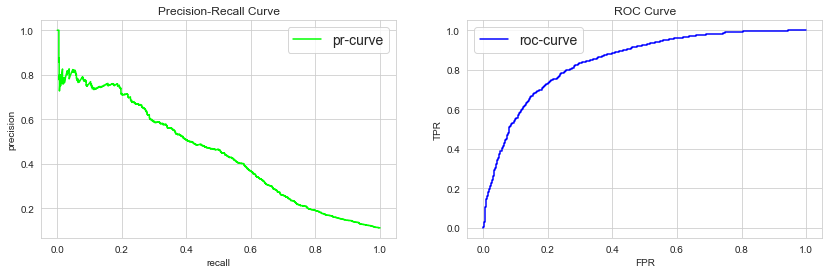

In [26]:
from sklearn.preprocessing import OneHotEncoder
logreg = construct_model(type_, OneHotEncoder(), num, cat, X_train, y_train)
lr_pred = logreg.decision_function(X_test)
pr, rec, _ = precision_recall_curve(y_test, lr_pred)

print('LR AUC-PR = %.5f' % auc(rec, pr))

type_ = LogisticRegression(max_iter=100000, penalty='l2', solver='sag')
logreg = construct_model(type_, OneHotEncoder(), num, cat, X_train, y_train, scaling=True, timeit=False)
lr_pred = logreg.decision_function(X_test)
pr, rec, _ = precision_recall_curve(y_test, lr_pred)
print('LR with scaling AUC-PR = %.5f' % auc(rec, pr))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
ax1 = draw_PR(rec, pr, ax=ax1)
ax2 = draw_ROC(fpr, tpr, ax=ax2)
plt.show()

Времени потребовалось больше, но качество при этом улучшилось. PR-график стал более ровным.

Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — mean-target encoding (для простоты будем называть это счётчиками). Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 5 (1 балл).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков). Заметили ли вы что-то интересное?


__Бонус (1 балл)__: Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их. 


In [27]:
from sklearn.base import BaseEstimator, TransformerMixin

class TargetEncodingMean(BaseEstimator, TransformerMixin):
    
    def __init__(self, cat):
        self.cat = cat
      
    def fit(self, X, y):
        self.X = X
        self.y = y
        
        X_copy = X.copy()
        X_copy['class'] = y
        self.d = dict.fromkeys(self.cat)
        for column in self.cat:
            self.d[column] = dict(X_copy.groupby(column)['class'].mean())
            
        return self
        
    def transform(self, X):
        X_transformed = X.copy()
        
        for column in self.cat:            
            X_transformed[column].replace(self.d[column], inplace=True)
        return X_transformed
    
transformer = TargetEncodingMean(cat).fit(X_train, y_train)
df_new = transformer.transform(X_test)
df_new.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
39949,69,0.255598,0.105111,0.112726,0.128569,0.115024,0.113835,0.051505,0.104400,0.110226,5,999,0,0.088848,-1.7,94.055,-39.8,0.748,4991.6
21502,36,0.129947,0.101269,0.139504,0.051851,0.110367,0.113835,0.147733,0.107735,0.116210,3,999,0,0.088848,1.4,93.444,-36.1,4.963,5228.1
8188,40,0.067515,0.101269,0.082738,0.051851,0.115024,0.113835,0.051505,0.104400,0.116210,1,999,0,0.088848,1.4,94.465,-41.8,4.864,5228.1
32930,28,0.109059,0.139834,0.112726,0.128569,0.115024,0.113835,0.051505,0.063396,0.098027,1,999,1,0.142140,-1.8,92.893,-46.2,1.299,5099.1
17981,35,0.112282,0.139834,0.139504,0.128569,0.115024,0.113835,0.147733,0.093472,0.116210,23,999,0,0.088848,1.4,93.918,-42.7,4.961,5228.1


Хочу проверить, все ли ок. Посмотрим, есть ли у нас такие категории, которые есть в тестовой выборке, но на тренировочной таких нет:

In [28]:
for column in cat:
    print(column)
    if set(X_train[column].unique()) != set(X_test[column].unique()):
        break

job
marital
education
default


In [29]:
set(X_train['default'].unique()), set(X_test['default'].unique())

({'no', 'unknown', 'yes'}, {'no', 'unknown'})

In [30]:
for column in cat[4:]:
    print(column)
    if set(X_train[column].unique()) != set(X_test[column].unique()):
        break

housing
loan
contact
month
day_of_week
poutcome


Таких категорий нет, все ок.

Fitting time: 20.39616
LR AUC-PR = 0.41673
LR with scaling AUC-PR = 0.44230


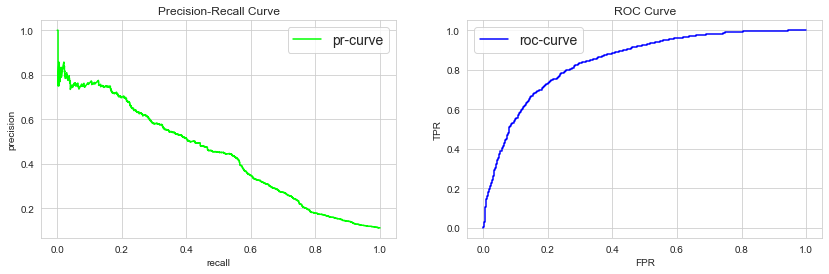

In [31]:
logreg = construct_model(type_, TargetEncodingMean(cat), num, cat, X_train, y_train)
lr_pred = logreg.decision_function(X_test)
pr, rec, _ = precision_recall_curve(y_test, lr_pred)

print('LR AUC-PR = %.5f' % auc(rec, pr))

type_ = LogisticRegression(max_iter=100000, penalty='l2', solver='sag')
logreg = construct_model(type_, TargetEncodingMean(cat), num, cat, X_train, y_train, scaling=True, timeit=False)
lr_pred = logreg.decision_function(X_test)
pr, rec, _ = precision_recall_curve(y_test, lr_pred)
print('LR with scaling AUC-PR = %.5f' % auc(rec, pr))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
ax1 = draw_PR(rec, pr, ax=ax1)
ax2 = draw_ROC(fpr, tpr, ax=ax2)
plt.show()

Было:
* Fitting time: 4.26666
* LR AUC-PR = 0.40689
* LR with scaling AUC-PR = 0.44185

Время сборки существенно уменьшилось, качество несущественно ухудшилось.

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 6.__ Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

__(0.5 балла)__

In [32]:
class NoisyTargetEncodingMean(BaseEstimator, TransformerMixin):
    
    def __init__(self, cat, dist, dist_params: list):
        self.cat = cat
        self.dist = dist
        self.dist_params = dist_params
      
    def fit(self, X, y):
        self.X = X
        self.y = y
        
        X_copy = X.copy()
        X_copy['class'] = y
        self.d = dict.fromkeys(self.cat)
        for column in self.cat:
            n = X_copy[column].unique().shape[0]
            self.d[column] = dict(X_copy.groupby(column)['class'].mean() + self.dist(*self.dist_params, n))
            
        return self
        
    def transform(self, X):
        X_transformed = X.copy()
        
        for column in self.cat:            
            X_transformed[column].replace(self.d[column], inplace=True)
        return X_transformed
    
transformer = NoisyTargetEncodingMean(cat, np.random.uniform, [0, 1]).fit(X_train, y_train)
df_new = transformer.transform(X_test)
df_new.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
39949,69,0.389145,0.654923,0.959445,1.110647,0.841611,0.458428,0.701684,1.033159,0.609777,5,999,0,0.534160,-1.7,94.055,-39.8,0.748,4991.6
21502,36,1.027970,1.073719,0.615958,0.552283,0.946049,0.458428,0.322298,0.738531,0.848287,3,999,0,0.534160,1.4,93.444,-36.1,4.963,5228.1
8188,40,0.929193,1.073719,0.397372,0.552283,0.841611,0.458428,0.701684,1.033159,0.848287,1,999,0,0.534160,1.4,94.465,-41.8,4.864,5228.1
32930,28,1.020936,0.684838,0.959445,1.110647,0.841611,0.458428,0.701684,1.035136,0.484662,1,999,1,0.508149,-1.8,92.893,-46.2,1.299,5099.1
17981,35,0.993406,0.684838,0.615958,1.110647,0.841611,0.458428,0.322298,1.071927,0.848287,23,999,0,0.534160,1.4,93.918,-42.7,4.961,5228.1


In [33]:
logreg = construct_model(type_, NoisyTargetEncodingMean(cat, np.random.uniform, [-0.05, 0.05]),
                                                         num, cat, X_train, y_train)
lr_pred = logreg.decision_function(X_test)
pr, rec, _ = precision_recall_curve(y_test, lr_pred)

print('LR AUC-PR = %.5f' % auc(rec, pr))

type_ = LogisticRegression(max_iter=100000, penalty='l2', solver='sag')
logreg = construct_model(type_, NoisyTargetEncodingMean(cat, np.random.uniform, [-0.05, 0.05]),
                                                         num, cat, X_train, y_train, scaling=True, timeit=False)
lr_pred = logreg.decision_function(X_test)
pr, rec, _ = precision_recall_curve(y_test, lr_pred)
print('LR with scaling AUC-PR = %.5f' % auc(rec, pr))

Fitting time: 21.64632
LR AUC-PR = 0.41676
LR with scaling AUC-PR = 0.43979


Качество ожидаемо упало. Зато теперь меньше вероятность переобучения.

__(Бонусная часть, 0.5 балла)__ Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум). 



In [34]:
#your code here

А теперь ответьте на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? 

*Получим некорректные средние значение таргета. Например, если у нас выборка из автомобилей девяностых-двухтысячных годов, и в ней встречаются несколько автомобилей с 70-х годов, которые являются раритетными и дорогими. Тогда алгоритм будет считать, что автомобили 70-х годов - дорогие, что не всегда так.*

По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (например, можно использовать 10 или подобрать для каждого признака свой). Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!


__Задание 7 (1 балл).__ Добавьте сглаживание, описанное выше и повторите эксперименты.

In [35]:
class NoisySmoothTargetEncodingMean(BaseEstimator, TransformerMixin):
    
    def __init__(self, cat, dist, dist_params: list, C, prior=None):
        self.cat = cat
        self.dist = dist
        self.dist_params = dist_params
        self.C = C
        self.prior = prior
      
    def fit(self, X, y):
        self.X = X
        self.y = y
        X_copy = X.copy()
        X_copy['class'] = y
        self.d = dict.fromkeys(self.cat)
        for column in self.cat:
            n = X_copy[column].unique().shape[0]
            tmp = X_copy.groupby(column)['class']
            
            gm_pr = X_copy['class'].mean()
            if self.prior is not None:
                gm_pr = self.prior
                
            self.d[column] = dict( (tmp.sum() + self.C * gm_pr) / (tmp.count() + self.C)
                                  + self.dist(*self.dist_params, n))
        return self
        
    def transform(self, X):
        X_transformed = X.copy()
        
        for column in self.cat:            
            X_transformed[column].replace(self.d[column], inplace=True)
        return X_transformed
    
transformer = NoisySmoothTargetEncodingMean(cat, np.random.uniform, [0, 1], 10).fit(X_train, y_train)
df_new = transformer.transform(X_test)
df_new.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
39949,69,0.894368,0.959284,0.678406,0.704773,0.713728,0.756912,0.672750,0.286568,1.044151,5,999,0,0.859952,-1.7,94.055,-39.8,0.748,4991.6
21502,36,0.766321,0.754956,0.424864,0.315110,0.638240,0.756912,0.165993,0.601405,0.215800,3,999,0,0.859952,1.4,93.444,-36.1,4.963,5228.1
8188,40,0.294249,0.754956,0.111783,0.315110,0.713728,0.756912,0.672750,0.286568,0.215800,1,999,0,0.859952,1.4,94.465,-41.8,4.864,5228.1
32930,28,0.320409,0.628702,0.678406,0.704773,0.713728,0.756912,0.672750,0.580085,0.915884,1,999,1,0.775289,-1.8,92.893,-46.2,1.299,5099.1
17981,35,0.487078,0.628702,0.424864,0.704773,0.713728,0.756912,0.165993,0.526126,0.215800,23,999,0,0.859952,1.4,93.918,-42.7,4.961,5228.1


In [36]:
logreg = construct_model(type_, NoisySmoothTargetEncodingMean(cat, np.random.uniform, [-0.05, 0.05], 300, 0.7),
                                                               num, cat, X_train, y_train)
lr_pred = logreg.decision_function(X_test)
pr, rec, _ = precision_recall_curve(y_test, lr_pred)

print('LR AUC-PR = %.5f' % auc(rec, pr))

type_ = LogisticRegression(max_iter=100000, penalty='l2', solver='sag')
logreg = construct_model(type_, NoisySmoothTargetEncodingMean(cat, np.random.uniform, [-0.05, 0.05], 300, 0.7),
                                                               num, cat, X_train, y_train, scaling=True, timeit=False)
lr_pred = logreg.decision_function(X_test)
pr, rec, _ = precision_recall_curve(y_test, lr_pred)
print('LR with scaling AUC-PR = %.5f' % auc(rec, pr))

Fitting time: 23.54960
LR AUC-PR = 0.41679
LR with scaling AUC-PR = 0.43475


Если брать малые значения `C`, то особо ничего не изменится. Если же брать большие (сравнимые с размером выборки), то качество будет падать значительно. Чем выше значение `prior`, тем хуже качество.

__Задание 8 (0.5 балла).__ В данных имеется признак "возраст клиента". Сейчас мы интерпретируем его как числовой, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этого признака есть довольно много уникальных значений (сколько? -- 78), поэтому применять к нему one-hot кодирование может оказаться излишним. Попробуйте закодировать возраст с помощью счетчиков. Стало ли лучше?



In [38]:
df['age'].unique().shape[0]

78

In [39]:
num_ = ['campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
cat_ = ['job', 'marital', 'education', 'default', 'housing',
        'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'age']

logreg = construct_model(type_,
                         NoisySmoothTargetEncodingMean(cat_, np.random.uniform, [-0.05, 0.05], 300, 0.7),
                         num_, cat_, X_train, y_train)

lr_pred = logreg.decision_function(X_test)
pr, rec, _ = precision_recall_curve(y_test, lr_pred)

print('LR AUC-PR = %.5f' % auc(rec, pr))

type_ = LogisticRegression(max_iter=100000, penalty='l2', solver='sag')
logreg = construct_model(type_,
                         NoisySmoothTargetEncodingMean(cat_, np.random.uniform, [-0.05, 0.05], 300, 0.7),
                         num_, cat_, X_train, y_train, scaling=True, timeit=False)

lr_pred = logreg.decision_function(X_test)
pr, rec, _ = precision_recall_curve(y_test, lr_pred)
print('LR with scaling AUC-PR = %.5f' % auc(rec, pr))

Fitting time: 21.73866
LR AUC-PR = 0.41972
LR with scaling AUC-PR = 0.44326


По моему мнению, стало очень незначительно лучше.

Можно пойти и в обратную сторону. У нас есть признаки "месяц и день недели" для звонка. Попробуйте интерпретировать их как числовые (месяц от 0 до 12, дни недели от 0 до 4). Стало ли лучше в этот раз?

In [40]:
df['day_of_week'].unique(), df['month'].unique(), 

(array(['mon', 'tue', 'wed', 'thu', 'fri'], dtype=object),
 array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'mar', 'apr',
        'sep'], dtype=object))

In [41]:
# Вообще мы делаем Label Encoding
days = {'mon':0, 'tue':1, 'wed':2, 'thu':3, 'fri':4}
months = {'mar':2, 'apr':3, 'may':4, 'jun':5, 'jul':6, 'aug':7, 'sep':8, 'oct':9, 'nov':10, 'dec':11}

num_ = ['campaign', 'pdays', 'previous', 'emp.var.rate', 'month', 'day_of_week', 
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
cat_ = ['job', 'marital', 'education', 'default', 'housing',
        'loan', 'contact', 'poutcome', 'age']

class MiniTransform(BaseEstimator, TransformerMixin):
    
    def __init__(self, days: dict, months: dict):
        self.days = days
        self.months = months
      
    def fit(self, X, y):
        self.X = X
        self.y = y
        return self
        
    def transform(self, X):
        X_transformed = X.copy()
        X_transformed['day_of_week'].replace(self.days, inplace=True)
        X_transformed['month'].replace(self.months, inplace=True)
        return X_transformed

transformer = MiniTransform(days, months)
X_train_new = transformer.transform(X_train)
X_test_new = transformer.transform(X_test)
    
    
logreg = construct_model(type_,
                         NoisySmoothTargetEncodingMean(cat_, np.random.uniform, [-0.05, 0.05], 300, 0.7),
                         num_, cat_, X_train_new, y_train)

lr_pred = logreg.decision_function(X_test_new)
pr, rec, _ = precision_recall_curve(y_test, lr_pred)

print('LR AUC-PR = %.5f' % auc(rec, pr))

type_ = LogisticRegression(max_iter=100000, penalty='l2', solver='sag')
logreg = construct_model(type_,
                         NoisySmoothTargetEncodingMean(cat_, np.random.uniform, [-0.05, 0.05], 300, 0.7),
                         num_, cat_, X_train_new, y_train, scaling=True, timeit=False)

lr_pred = logreg.decision_function(X_test_new)
pr, rec, _ = precision_recall_curve(y_test, lr_pred)
print('LR with scaling AUC-PR = %.5f' % auc(rec, pr))

Fitting time: 20.69384
LR AUC-PR = 0.41636
LR with scaling AUC-PR = 0.43277


Лучше не стало.

__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ Тратится меньше времени и памяти для преобразования, а качество без скалирования лучше. При этом, что можно заметить, качество со скалированием получается сравнимым и меняется в пределах одной сотой.

# Часть 2. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про банковский телефонный маркетинг.

In [42]:
df = pd.read_csv('data/bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes').astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

Как вы помните, в данных много категориальных признаков (сейчас давайте интерпретировать возраст как числовой). Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

In [43]:
encoder = OneHotEncoder(handle_unknown='ignore').fit(X_train[cat])
X_train_ = encoder.transform(X_train[cat])
X_test_ = encoder.transform(X_test[cat])
X_train_.shape[1], X_test_.shape[1]

(53, 53)

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [44]:
logreg = construct_model(type_, OneHotEncoder(), num, cat, X_train, y_train, timeit=False)
lr_pred = logreg.decision_function(X_test)
pr, rec, _ = precision_recall_curve(y_test, lr_pred)
print('LR AUC-PR = %.5f' % auc(rec, pr))

logreg_scale = construct_model(type_, OneHotEncoder(), num, cat, X_train, y_train, scaling=True, timeit=False)
lr_pred = logreg_scale.decision_function(X_test)
pr, rec, _ = precision_recall_curve(y_test, lr_pred)
print('LR with scaling AUC-PR = %.5f' % auc(rec, pr))

LR AUC-PR = 0.44262
LR with scaling AUC-PR = 0.44729


### Встроенные методы

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отбора признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

__Задание 9 (0.5 балла).__ Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?



In [45]:
import operator
weights = logreg.named_steps['modeling'].coef_.flatten()
d = weights.shape[0]

start_time = datetime.now()
features = dict(enumerate(abs(weights)))
features = dict(sorted(features.items(), key=operator.itemgetter(1), reverse=True))
columns_idx = list(features.keys())[:40]
print('Time spent: %.5f' % (datetime.now() - start_time).total_seconds())

Time spent: 0.00000


Здесь я предполагаю, что время взятия среза (см. ячейку ниже) незначительное, поэтому сориентируемся таким образом: 99% времени уходит на получение весов для дальнейшего отбора (обучение модели).

In [46]:
def triv_transform(X_train, X_test, num, cat, idx=None, scaling=0):
    
    '''
        scaling = 0: no scaling at all
        scaling = 1: scaling of numeric
        scaling = 2: scaling of all
    '''
    
    column_transformer = ColumnTransformer([
        ('encoding', OneHotEncoder(), cat),
        ('nothing', 'passthrough', num)
    ])
    
    if scaling == 1:
        column_transformer = ColumnTransformer([
            ('encoding', OneHotEncoder(), cat),
            ('scaling', StandardScaler(), num)
        ])
    
    transformer = column_transformer.fit(X_train)
    X_train_ = transformer.transform(X_train)
    X_test_ = transformer.transform(X_test)
    
    if scaling == 2:
        scaler = StandardScaler().fit(X_train_)
        X_train_ = scaler.transform(X_train_)
        X_test_ = scaler.transform(X_test_)
    
    if idx is not None:
        return X_train_[:, idx], X_test_[:, idx]
    return X_train_, X_test_

In [49]:
X_train_, X_test_ = triv_transform(X_train, X_test, num, cat, idx=columns_idx)
X_train_.shape, X_test_.shape

((32950, 40), (8238, 40))

In [50]:
logreg = LogisticRegression(max_iter=100000, penalty='l2', solver='sag').fit(X_train_, y_train)
lr_pred = logreg.decision_function(X_test_)
pr, rec, _ = precision_recall_curve(y_test, lr_pred)
print('LR AUC-PR = %.5f' % auc(rec, pr))

LR AUC-PR = 0.44274


Качество стало совсем чуть лучше (0.44274 против 0.44262 - без скалирования).

А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [51]:
weights_scale = logreg_scale.named_steps['modeling'].coef_.flatten()
d_scale = weights_scale.shape[0]

features_scale = dict(enumerate(abs(weights_scale)))
features_scale = dict(sorted(features_scale.items(), key=operator.itemgetter(1), reverse=True))
columns_idx_scale = list(features_scale.keys())[:40]

In [52]:
X_train_, X_test_ = triv_transform(X_train, X_test, num, cat, idx=columns_idx_scale, scaling=1)

logreg = LogisticRegression(max_iter=100000, penalty='l2', solver='sag').fit(X_train_, y_train)
lr_pred = logreg.decision_function(X_test_)
pr, rec, _ = precision_recall_curve(y_test, lr_pred)
print('LR with scaling AUC-PR = %.5f' % auc(rec, pr))

LR with scaling AUC-PR = 0.44905


По сравнению с тем, что было, улучшение более заметное (0.44729 против 0.44905).

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

Сначала просто обучим и выделим признаки.

In [53]:
X_train_, X_test_ = triv_transform(X_train, X_test, num, cat, idx=columns_idx_scale, scaling=2)
logreg_scale_all = LogisticRegression(max_iter=100000, penalty='l2', solver='sag').fit(X_train_, y_train)
lr_pred = logreg_scale_all.decision_function(X_test_)
pr, rec, _ = precision_recall_curve(y_test, lr_pred)
print('LR with scaling AUC-PR = %.5f' % auc(rec, pr))

weights_scale_all = logreg_scale_all.coef_.flatten()
d_scale_all = weights_scale_all.shape[0]

features_scale_all = dict(enumerate(abs(weights_scale_all)))
features_scale_all = dict(sorted(features_scale_all.items(), key=operator.itemgetter(1), reverse=True))
columns_idx_scale_all = list(features_scale_all.keys())[:40]

LR with scaling AUC-PR = 0.44893


In [54]:
X_train_, X_test_ = triv_transform(X_train, X_test, num, cat, idx=columns_idx_scale_all, scaling=2)

logreg = LogisticRegression(max_iter=100000, penalty='l2', solver='sag').fit(X_train_, y_train)
lr_pred = logreg.decision_function(X_test_)
pr, rec, _ = precision_recall_curve(y_test, lr_pred)
print('LR with scaling of all AUC-PR = %.5f' % auc(rec, pr))

LR with scaling of all AUC-PR = 0.27083


Качество упало очень сильно. Посмотрим как изменился список отобранных признаков:

In [55]:
features_scale_all.keys()

dict_keys([0, 2, 6, 14, 4, 3, 15, 12, 7, 8, 1, 5, 21, 9, 22, 10, 17, 27, 11, 37, 28, 24, 36, 23, 16, 31, 18, 13, 20, 29, 26, 32, 38, 33, 34, 35, 25, 30, 39, 19])

In [56]:
features_scale.keys()

dict_keys([57, 40, 58, 39, 41, 42, 61, 34, 50, 36, 46, 5, 33, 37, 60, 55, 8, 1, 52, 20, 35, 59, 54, 16, 25, 43, 44, 26, 49, 10, 15, 13, 3, 12, 28, 31, 7, 24, 21, 11, 18, 4, 19, 14, 32, 38, 29, 51, 47, 56, 2, 45, 6, 27, 17, 22, 53, 9, 0, 30, 23, 48])

### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

__Задание 10 (0.5 балла).__ Оставьте 40 признаков с наибольшим значением $t$ и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случае.



In [68]:
class T_transformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, n=40):
        self.n = n
      
    def fit(self, X, y):
        self.X = X
        self.y = y.reset_index().drop(columns='index')
        self.idx_plus = self.y.loc[self.y['y'] == 1].index.to_list()
        self.idx_minus = self.y.loc[self.y['y'] == 0].index.to_list()
        self.n_plus = len(self.idx_plus)
        self.n_minus = len(self.idx_minus)
        
        features = {}
        for feature in range(self.X.shape[1]):
            X_plus = X[self.idx_plus, feature]
            X_minus = X[self.idx_minus, feature]
            
            u_plus = np.mean(X_plus)
            u_minus = np.mean(X_minus)
            s_plus = np.std(X_plus)
            s_minus = np.std(X_minus)
            
            features[feature] = abs(u_plus - u_minus) / np.sqrt(
                    (self.n_plus * s_plus ** 2 + self.n_minus * s_minus ** 2) /
                    (self.n_plus + self.n_minus)
                )
            
        features = dict(sorted(features.items(), key=operator.itemgetter(1), reverse=True))
        self.columns_idx = list(features.keys())[:self.n]
        return self
        
    def transform(self, X):
        return X[:, self.columns_idx]

X_train_, X_test_ = triv_transform(X_train, X_test, num, cat, scaling=1)

start_time = datetime.now()
transformer__ = T_transformer().fit(X_train_, y_train)
print('Time spent: %.5f' % (datetime.now() - start_time).total_seconds())
X_train__ = transformer__.transform(X_train_)
X_test__ = transformer__.transform(X_test_)

Time spent: 0.13710


In [69]:
logreg = LogisticRegression(max_iter=100000, penalty='l2', solver='sag').fit(X_train__, y_train)
lr_pred = logreg.decision_function(X_test__)
pr, rec, _ = precision_recall_curve(y_test, lr_pred)
print('LR with scaling of all AUC-PR = %.5f' % auc(rec, pr))

LR with scaling of all AUC-PR = 0.45120


Рекорд по данному ноутбуку побит. Был использован OHE со скалированием только числовых признаков, затем данные обрезалились согласно заданию.

### Методы-обёртки

__Задание 11 (1 балл).__ 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [70]:
# pip install mlxtend

**Отбор с удалением (backward)**

In [71]:
# http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/
# http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/#api - interface
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import make_scorer

def PR_scoring(y_true, y_pred):
    pr, rec, _ = precision_recall_curve(y_true, y_pred)
    return auc(rec, pr)

custom_scoring = make_scorer(PR_scoring, greater_is_better=True)
estimator = LogisticRegression(max_iter=100000, penalty='l2', solver='sag')

feature_selector = SFS(estimator, forward=False, k_features=40, verbose=1, scoring=custom_scoring, cv=2, n_jobs=-1)
# Plotting: http://rasbt.github.io/mlxtend/user_guide/plotting/plot_sequential_feature_selection/

start_time = datetime.now()
# X_train_ - OHE + scaling of numeric
feature_selector.fit(X_train_, y_train)
print('Fitting time: %.5f' % (datetime.now() - start_time).total_seconds())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  62 out of  62 | elapsed:  2.6min finished
Features: 61/40[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:  2.6min finished
Features: 60/40[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.9min finished
Features: 59/40[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:  2.9min finished
Features: 58/40[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 

Fitting time: 2804.92523


После утомительного ожидания получаем качество по `PR-AUC`:

In [73]:
feature_selector.k_score_

0.4965286472586423

Подробную информацию можно посмотреть в атрибьютах `k_feature_idx_ `, `k_feature_names_`, `subsets_`. Индексы выбранных признаков хранятся в `k_feature_idx_ `:

In [74]:
len(feature_selector.k_feature_idx_)

40

Проверим качество на тестовой выборке:

In [75]:
idx = list(feature_selector.k_feature_idx_)
logreg = LogisticRegression(max_iter=100000, penalty='l2', solver='sag').fit(X_train_[:, idx], y_train)
lr_pred = logreg.decision_function(X_test_[:, idx])
pr, rec, _ = precision_recall_curve(y_test, lr_pred)
print('LR with scaling AUC-PR = %.5f' % auc(rec, pr))

LR with scaling AUC-PR = 0.44877


Особых улучшений достигнуто не было. Но стало чуть лучше.

Замечу, что по моему опыту метод из `mlxtend` работает быстрее, чем аналогичный из `scikit`.

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [76]:
estimator = LogisticRegression(max_iter=100000, penalty='l2', solver='sag')
feature_selector_forward = SFS(estimator, forward=True, k_features=40, verbose=1, scoring=custom_scoring, cv=2, n_jobs=-1)

start_time = datetime.now()
feature_selector_forward.fit(X_train_, y_train)
print('Fitting time: %.5f' % (datetime.now() - start_time).total_seconds())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  62 out of  62 | elapsed:    1.3s finished
Features: 1/40[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 out of  61 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    1.2s finished
Features: 2/40[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.3s finished
Features: 3/40[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  59 | elapsed:    2.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:    2.4s finished
Features: 4/40[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   

Fitting time: 470.13417


Получаем качество:

In [77]:
feature_selector_forward.k_score_

0.4917881124029715

Визуализируем.

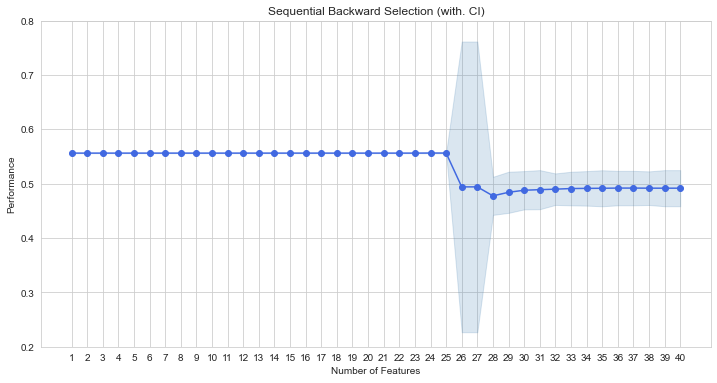

In [80]:
fig = plot_sfs(feature_selector_forward.get_metric_dict(),
         kind='ci', confidence_interval=0.99, color='royalblue', alpha=0.2, figsize=(12, 6))

# fig.set_size_inches(12, 6)
plt.ylim([0.2, 0.8])
plt.title('Sequential Backward Selection (with. CI)')
plt.show()

Картина выглядит, мягко говоря, странно: на числе признаков больше 25 мы получаем ухудшение качества и сильный разброс по доверительному интервалу `AUC-PR`. Далее ситуация чуть выравнивается.\
Оценим на тестовой выборке.

In [83]:
idx_forward = list(feature_selector_forward.k_feature_idx_)
X_train_, X_test_ = triv_transform(X_train, X_test, num, cat, scaling=1)
logreg = LogisticRegression(max_iter=100000, penalty='l2', solver='sag').fit(X_train_[:, idx_forward], y_train)
lr_pred = logreg.decision_function(X_test_[:, idx_forward])
pr, rec, _ = precision_recall_curve(y_test, lr_pred)
print('LR with scaling AUC-PR = %.5f' % auc(rec, pr))

LR with scaling AUC-PR = 0.42945


Видим явное ухудшение.

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** Выяснили, что лучше всего скалировать числовые признаки. Если этого не делать, качество будет плохое. Если же после OHE отскалировать все признаки, то мы получим сильное ухудшение качества, так как, как мне кажется, скалируя откодированные категориальные признаки мы вообще говоря уходим от сути OHE и получаем что-то странно. Это "что-то странное" прискорбно сказывается на качестве модели.\
Дальшейние методы судятся с учетом того, что преобразования совершались с предварительно скалированными данными:
* Отбор признаков на основе модулей весов чуть улучшаем модель;
* Backward-метод обертки работает крайне долго (около часа в лучшем случае), но при этом выдает улучшение качества;
* Forward-метод обертки работает достаточно долго (9-10 минут), но качество ухудшается;
* К наилучшему качеству привел метод фильтрации на основе t-статистики с предварительным OH-кодированием категориальных и скалированием числовых признаков. Кроме того, он работает достаточно быстро.
При всем этом, мы не получили сильного улучшения качества - всего лишь на тысячные доли. Возможно, какие-нибудь другие методы, описанные в [статье](https://habr.com/ru/company/jetinfosystems/blog/470622/) дали бы более заметный эффект.

# Часть 3. Оценка экономического эффекта модели

В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: мы соберем несколько специализированных метрик качества, попытаемся настроить модель на максимизацию _прибыли_ и оценим, сколько вообще получится заработать на этом. Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. 

__Задание 12 (1 балл).__ Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов.

Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.

Загрузите данные о телемаркетинге из предыдущего блока заданий. В этой части не нужно делить выборку - мы будем использовать кросс-валидацию. Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки. Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков, гиперпараметры оставьте со значениями по умолчанию) и сделайте предсказания для соответствующих тестовых выборок. Допустим, всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Сколько денег вы в среднем заработаете? Также вычислите стандартное отклонение.

Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [341]:
from sklearn.model_selection import KFold as k_fold
data = pd.read_csv('data/bank-additional/bank-additional-full.csv', sep=';')
X = data.drop(columns=['duration', 'y'])
y = (data.y == 'yes').astype(int)

num = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
cat = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

cv = k_fold(n_splits=5, random_state=500, shuffle=True)
type_ = LogisticRegression(max_iter=100000, penalty='l2', solver='sag')

revenues = []
salaries = []
for train_index, test_index in cv.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    model = construct_model(type_, OneHotEncoder(), num, cat, X_train, y_train, scaling=True, timeit=False)
    y_preds = model.predict(X_test)
    
    calls_made = np.sum(y_preds) # = money spent on calls
    salaries.append(calls_made)
    success = np.sum(y_preds * y_test)
    
    revenues.append(10 * success - calls_made)

TRAIN: [    0     1     2 ... 41185 41186 41187] TEST: [    5     6    10 ... 41160 41176 41177]
TRAIN: [    1     2     3 ... 41184 41185 41186] TEST: [    0     8    21 ... 41164 41183 41187]
TRAIN: [    0     1     3 ... 41183 41184 41187] TEST: [    2     4     7 ... 41181 41185 41186]
TRAIN: [    0     1     2 ... 41185 41186 41187] TEST: [    3    11    14 ... 41178 41182 41184]
TRAIN: [    0     2     3 ... 41185 41186 41187] TEST: [    1     9    12 ... 41168 41170 41179]


In [342]:
print('Выручка: \n\t Средняя: %f \n\t Максимальная: %f \
    \n\t Минимальная: %f \n\t Стандартное отклонение: %f \n' 
    % (sum(revenues) / 5, max(revenues), min(revenues), np.std(np.array(revenues))))
print('Оплата услуг call-центра: \n\t Средняя: %f \n\t Максимальная: %f \
    \n\t Минимальная: %f' 
    % (sum(salaries) / 5, max(salaries), min(salaries)))

Выручка: 
	 Средняя: 1807.600000 
	 Максимальная: 1930.000000     
	 Минимальная: 1648.000000 
	 Стандартное отклонение: 105.938850 

Оплата услуг call-центра: 
	 Средняя: 324.400000 
	 Максимальная: 330.000000     
	 Минимальная: 310.000000


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [343]:
cv = k_fold(n_splits=5, random_state=None, shuffle=True)

revenues = []
salaries = []
for train_index, test_index in cv.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    model = construct_model(type_, OneHotEncoder(), num, cat, X_train, y_train, scaling=True, timeit=False)
    y_preds = model.predict(X_test)
    
    calls_made = np.sum(y_preds) # = money spent on calls
    salaries.append(calls_made)
    success = np.sum(np.random.uniform(0, 20, y_test.shape[0]) * y_preds * y_test)
    
    revenues.append(success - calls_made)

TRAIN: [    0     2     3 ... 41185 41186 41187] TEST: [    1     5    11 ... 41165 41173 41177]
TRAIN: [    0     1     2 ... 41184 41186 41187] TEST: [    4     7    10 ... 41179 41181 41185]
TRAIN: [    1     2     4 ... 41184 41185 41187] TEST: [    0     3     8 ... 41176 41183 41186]
TRAIN: [    0     1     3 ... 41184 41185 41186] TEST: [    2    15    27 ... 41169 41178 41187]
TRAIN: [    0     1     2 ... 41185 41186 41187] TEST: [    6    14    17 ... 41180 41182 41184]


In [344]:
print('Выручка: \n\t Средняя: %f \n\t Максимальная: %f \
    \n\t Минимальная: %f \n\t Стандартное отклонение: %f \n' 
    % (sum(revenues) / 5, max(revenues), min(revenues), np.std(np.array(revenues))))
print('Оплата услуг call-центра: \n\t Средняя: %f \n\t Максимальная: %f \
    \n\t Минимальная: %f' 
    % (sum(salaries) / 5, max(salaries), min(salaries)))

Выручка: 
	 Средняя: 1736.361851 
	 Максимальная: 1856.960824     
	 Минимальная: 1624.287598 
	 Стандартное отклонение: 81.588815 

Оплата услуг call-центра: 
	 Средняя: 317.000000 
	 Максимальная: 339.000000     
	 Минимальная: 294.000000


Так как матожидание у $U[0, 20]$ равно 10, мы в среднем получаем такую же выручку при похожих (средних) затратах.

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, также укажите стандартные отклонения (вам поможет `plt.errorbar`).

In [345]:
from sklearn.model_selection import GridSearchCV
def profit_scoring(y_true, y_pred):
    success = np.sum(np.random.uniform(0, 20, y_test.shape[0]) * y_preds * y_test)
    return success

profit_score = make_scorer(profit_scoring, greater_is_better=True)

Cs = np.logspace(-4, -2, 30)

model = construct_model(type_, OneHotEncoder(), num, cat, X_train, y_train, scaling=True, timeit=False, fit=False)
searcher = GridSearchCV(model, [{'modeling__C': Cs}], scoring=profit_score, cv=cv, n_jobs=-1)
_ = searcher.fit(X, y)

In [346]:
searcher.best_params_['modeling__C'], searcher.best_score_

(0.0002592943797404667, 2065.095407531272)

Получили коэффициент при котором прибыль должна быть максимальна.

In [347]:
# searcher.cv_results_

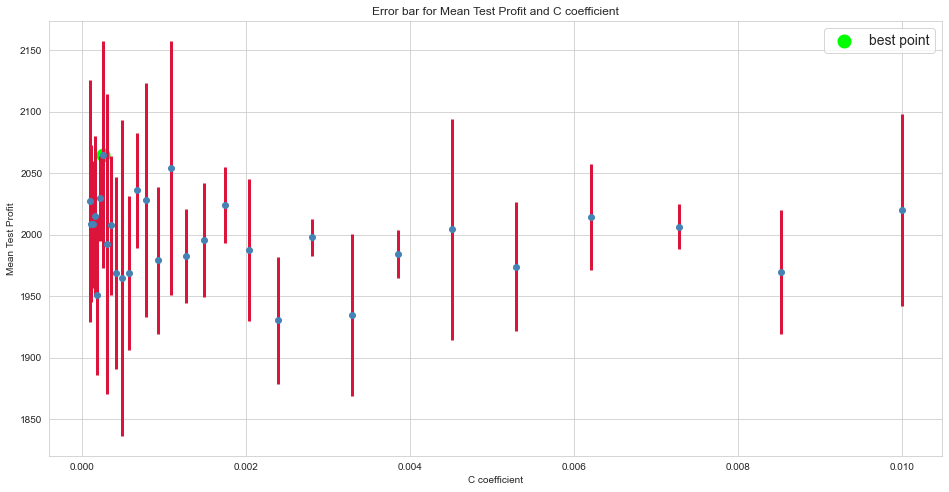

In [348]:
plt.rcParams['figure.figsize'] = 16, 8
plt.errorbar(x=Cs, y=searcher.cv_results_['mean_test_score'], elinewidth=3, linewidth=3, fmt='o',
             yerr=searcher.cv_results_['std_test_score'], ecolor='crimson', c='steelblue')

plt.scatter(searcher.best_params_['modeling__C'], searcher.best_score_,
            label='best point', c='lime', linewidth=8)

plt.xlabel('C coefficient')
plt.ylabel('Mean Test Profit')
plt.title('Error bar for Mean Test Profit and C coefficient')
plt.legend(shadow=False, fontsize=14)
plt.show()

Ошибки выглядят очень большими. Посмотрим на прибыли с полученным коэффициентом.

In [349]:
type_ = LogisticRegression(max_iter=100000, penalty='l2', solver='sag', C=searcher.best_params_['modeling__C'])
cv = k_fold(n_splits=5, random_state=None, shuffle=True)

profits = []
revenues = []
for train_index, test_index in cv.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    model = construct_model(type_, OneHotEncoder(), num, cat, X_train, y_train, scaling=True, timeit=False)
    y_preds = model.predict(X_test)

    calls_made = np.sum(y_preds)
    success = np.sum(np.random.uniform(0, 20, y_test.shape[0]) * y_preds * y_test)
    profits.append(success)
    revenues.append(success - calls_made)
    
print('Прибыль: \n\t Средняя: %f \n\t Максимальная: %f \
    \n\t Минимальная: %f \n\t Стандартное отклонение: %f \n' 
    % (sum(profits) / 5, max(profits), min(profits), np.std(np.array(profits))))
print('Выручка: \n\t Средняя: %f \n\t Максимальная: %f \
    \n\t Минимальная: %f \n\t Стандартное отклонение: %f \n' 
    % (sum(revenues) / 5, max(revenues), min(revenues), np.std(np.array(revenues))))

Прибыль: 
	 Средняя: 1553.583258 
	 Максимальная: 1713.941156     
	 Минимальная: 1345.421978 
	 Стандартное отклонение: 137.121224 

Выручка: 
	 Средняя: 1337.983258 
	 Максимальная: 1499.941156     
	 Минимальная: 1129.421978 
	 Стандартное отклонение: 133.828846 



Судя по выводу, выигрыша не наблюдается (позапускал несколько раз - картина та же), а стандартное отклонение увеличилось. Однако мы явно получили выигрыш в ускорение подсчетов.

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

Processing...
Done!


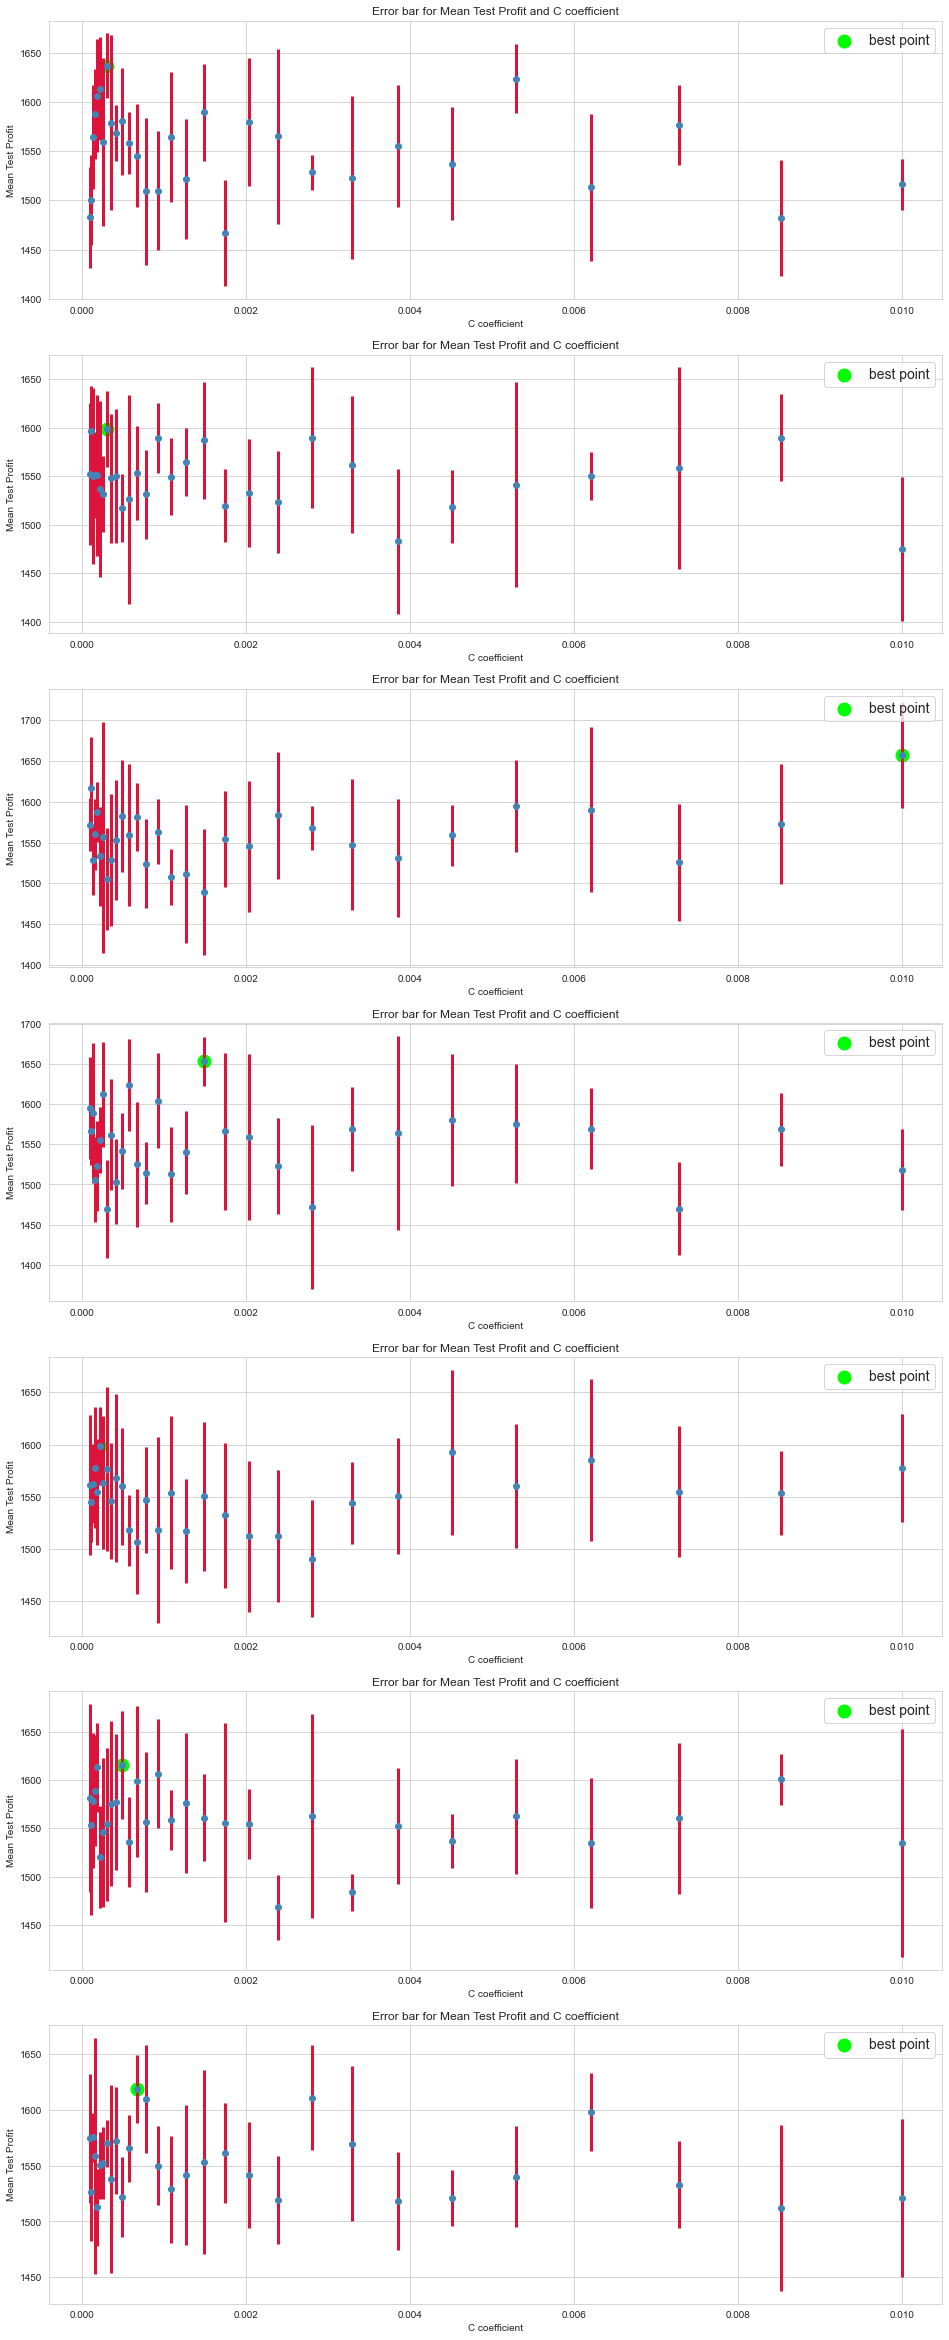

In [350]:
n = 7
fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(16, 6 * n))
print('Processing...')
for i in range(n):
    searcher = GridSearchCV(model, [{'modeling__C': Cs}], scoring=profit_score, cv=cv, n_jobs=-1)
    _ = searcher.fit(X, y)
    
    axes[i].errorbar(x=Cs, y=searcher.cv_results_['mean_test_score'], elinewidth=3, linewidth=3, fmt='o',
                 yerr=searcher.cv_results_['std_test_score'], ecolor='crimson', c='steelblue')

    axes[i].scatter(searcher.best_params_['modeling__C'], searcher.best_score_,
                label='best point', c='lime', linewidth=8)

    axes[i].set_xlabel('C coefficient')
    axes[i].set_ylabel('Mean Test Profit')
    axes[i].set_title('Error bar for Mean Test Profit and C coefficient')
    axes[i].legend(shadow=False, fontsize=14)
print('Done!')
plt.show()

Никакой закономерности не наблюдается - оптимальная точка скачет туда-обратно.

**Простите, но у меня уже нет сил это делать...**

__Задание 13 (1 балл).__ Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ **вообще говоря, я ответил на этот вопрос в задании 3.**



Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки порога бинаризации этих вероятностей мы сможем получить какой-то выигрыш? Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [355]:
#your code here

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

In [ ]:
#your code here

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [ ]:
#your code here

Как вы, вероятно, уже поняли, ваша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом - выберите только те пороги, на которых достигается необходимый recall, затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат и посчитайте площадь под отсеченной кривой. 

In [ ]:
#your code here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ хороший борщ, с капусткой, но не красной, сосисочки, непонятный салат, куда крошат морковку, капусту и яблоки с ананасами (вообще он меня бесит). Вкусный чай - он так утоляет жажду, я чувствую себя человеком. 

__Социализационный бонус (0.1 балл).__
Введены новые ограничения, занятия теперь дистанционные. Но это не значит, что не надо общаться с друзьями! Созвонитесь в зуме (или любым другим способом) хотя бы с двумя студентами курса МО-1 этого года, приложите скриншот созвона с включенными камерами и напишите очень кратко, на какие темы были беседы.

__Ответ:__ Поболтали о том, о сем, обсудили работу, стажировки, магистратуру. Где-то поугарали, где-то поплакали, пожаловались друг другу на это дз и пошли по своим делам.

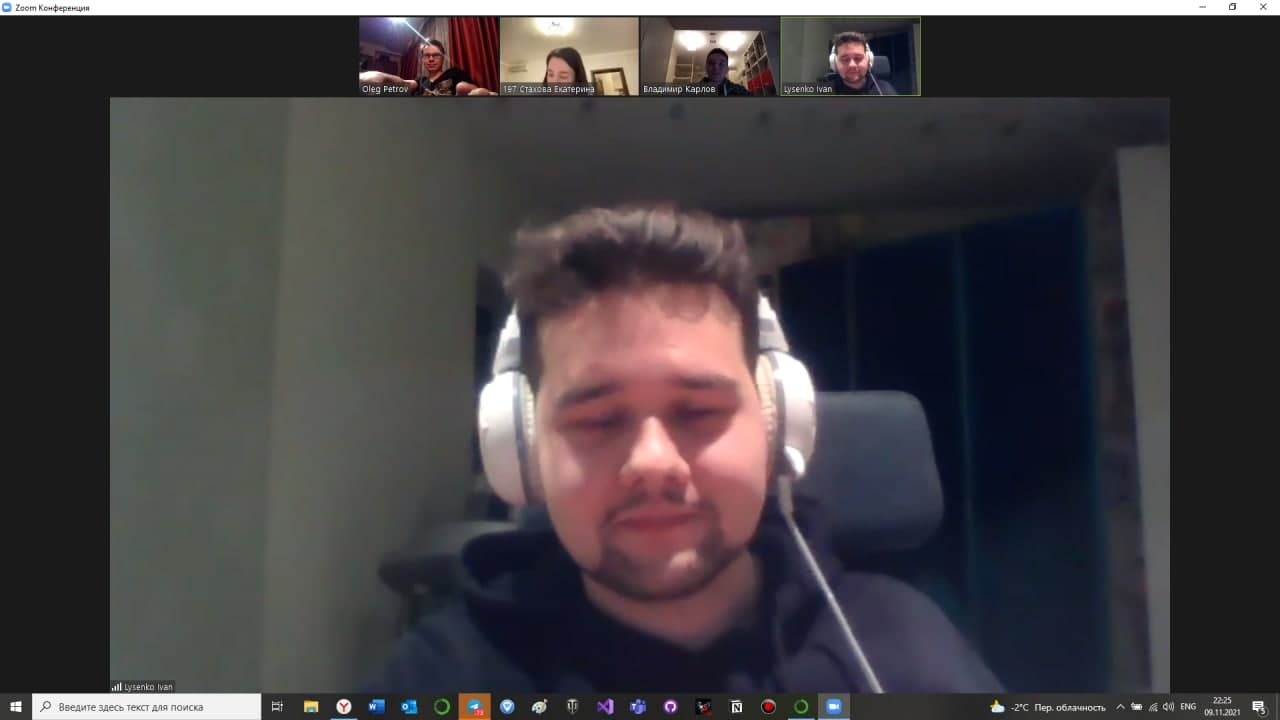